In [6]:
# To run this script install the Python and Jupyter Extension to vscode
# Then click "Select Python Kernel" and create a new virtual environment based on the requirements.txt file

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import os
# select file
from tkinter import * 
from tkinter.filedialog import askopenfilename #filepicker

Tk().withdraw() # don't show everything
filename = askopenfilename()
print(filename) #print filename to the console for debuggin

/home/johannes/Taupunktluefter/Daten/2024-12.CSV


In [4]:
# split up the file and path name

base, ext = os.path.splitext(filename)
path = os.path.dirname(base);
fileNameOnly = base.split("/")[-1];
origExt = ext;
#print(path)
#print(fileNameOnly)
#print(origExt)

fullOrigFileNamePath = path + os.path.sep + fileNameOnly + ext;
#print(fullOrigFileNamePath)

In [8]:
# Clean up the csv file before showing it by copying it into a new file

newFilename = path + os.path.sep + fileNameOnly + "_cor.csv"

fNew = open(newFilename,"w"); # open/overwrite corrected file
with open(fullOrigFileNamePath) as f:
    # go through the original file and ...
    for i, line in enumerate(f):
        line = line.rstrip('\n;') #re,ove trailing ; and newline if present and
        line = line + "\n"; # just add the newline again
        fNew.write(line)
        
fNew.close();
fileToAnalyze = newFilename;
print(fileToAnalyze)

/home/johannes/Taupunktluefter/DatenStrio/2025-02a_cor.csv


In [35]:
# read the file once to detect the repeated header rows
header_rows = []
header_start = "Date" # repeated Headers start with "Date"
with open(fileToAnalyze) as f:
    for i, line in enumerate(f):
        if line.endswith(";"):
            print("row",i, "ends with ;, which may lead to problems...");
        if line.startswith(header_start):
            header_rows.append(i)
        elif line.startswith('1970'):
            # 1970-0-0 kann nicht als datetime interpretiert werden, weil es kein Monat 0 gibt
            header_rows.append(i)
            
f.close();
# the first (real) row should always be detected
assert header_rows[0] == 0
# The header line is missing some how.... TODO: copy the following header file into the first line of the corrected file
# Date;Temperature T_i;Temperature T_o;Humidity H_i;Humidity H_o;Dew point DP_i;Dew point DP_o;validCnt_i;validCnt_o;Fan;Mode;On_s;Off_s
# skip all header rows except for the first one (the real one)
print(header_rows)

[0]


In [36]:
# usual import of the cleaned file
data = pd.read_csv(fileToAnalyze, sep=";", decimal="." 
                   , parse_dates=["Date"]
                   , index_col=["Date"]
                   , on_bad_lines='warn'
                   , skiprows=header_rows[1:]
                   #,dtype = {'Temperature T_o': np.float16},
                   );
print(len(data))
data

1682


,Temperature T_i,Temperature T_o,Humidity H_i,Humidity H_o,Dew point DP_i,Dew point DP_o,validCnt_i,validCnt_o,Fan,Mode,On_s,Off_s
Date,,,,,,,,,,,,
2025-02-05 11:57:09,18.4,15.0,55.3,53.0,9.3,5.5,8,8,f0,m1,0,288
2025-02-05 12:03:10,18.4,14.0,55.0,55.1,9.2,5.2,8,8,f0,m1,0,650
2025-02-05 12:09:12,18.5,13.4,55.9,57.1,9.6,5.1,8,8,f0,m1,0,1012
2025-02-05 12:15:13,18.6,13.1,56.3,58.5,9.7,5.2,8,8,f0,m1,0,1372
2025-02-05 12:21:14,18.6,12.8,57.0,58.8,9.9,5.0,8,8,f0,m1,0,1734
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 12:16:53,18.4,14.8,47.7,55.8,7.1,6.1,8,8,f1,m2,870,0
2025-02-12 12:22:54,18.3,14.0,48.6,35.3,7.3,-1.1,8,8,f0,m2,0,272
2025-02-12 12:28:56,18.4,11.9,48.8,44.9,7.5,0.3,8,8,f1,m2,34,0


In [37]:
# %% sortierung
data.sort_values(by=['Date'], inplace=True); # sort to date
data = data.loc['2020':]; # remove 1970 values
print(len(data))

1682


In [38]:
# %%  interesting date?
#data = data.loc['2024-04-09':'2024-04-11']

# %% replace values with n/a where validCnt = 0 because there are no measured data here
validO =  data['validCnt_o'] > 0;
validI =  data['validCnt_i'] > 0;

# %% get fan state and decode 
data['Fan'] = data['Fan'].astype('category')
categorie_codes = dict(enumerate(data['Fan'].cat.categories))
data['Fan'] = data['Fan'].cat.codes
print(categorie_codes)

{0: 'f0', 1: 'f1'}


In [39]:
# calculate how long the fan was running. using the onTime Value
# find local maxima, where the value before and behind is smaller.
localMax = ((data["On_s"].shift(1) < data["On_s"]) & (data["On_s"].shift(-1) < data["On_s"]))

totalOnTime_s = sum(data["On_s"][localMax]);

totalOnTime_h = int(round(totalOnTime_s/60/60,0));
totalOnTime_Hmin = int(round((totalOnTime_s/60)%60)); # minutes to hours
      
print(totalOnTime_s/60);
print(totalOnTime_h)
print(totalOnTime_Hmin)

4982.633333333333
83
3


In [40]:
# indicate limits in plot

#define DELTAP 3.0    // Der Taupunkt draußen muss um diese Gradzahl kleiner sein als drinnen, damit gelüftet wird
neccesDeltaP = 3;

# create time vector for lines in this plot
timeHelpVector = (data[validI].index[0], data[validI].index[-1])
# lineStyle for helper line https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
linestyleHelper = (0, (1, 5));

#define TEMP_I_MIN 10.0    // Minimale Innentemperatur, bei der die Lüftung nicht mehr aktiviert wird.
minTemp_i = 10;
#define TEMP_O_MIN -2.0    // Minimale Außentemperatur, bei der die Lüftung nicht mehr aktiviert wird.
minTemp_o = -2;
#define DEWPOINT_I_MIN 5.0 // Minimaler Taupunkt innen, nur oberhalb läuft der Lüfter
minDewPoint_i = 5;

colorI = 'orangered';
colorO = 'royalblue';

/tmp/ipykernel_17468/2323510868.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.axes[axisCount].arrow(timeHelpVector[0], data[validI]["Dew point DP_o"][0]+neccesDeltaP, 0, -neccesDeltaP, width=.01, label=u'Notw. ΔT = ' +str(neccesDeltaP)+" K", color='green');


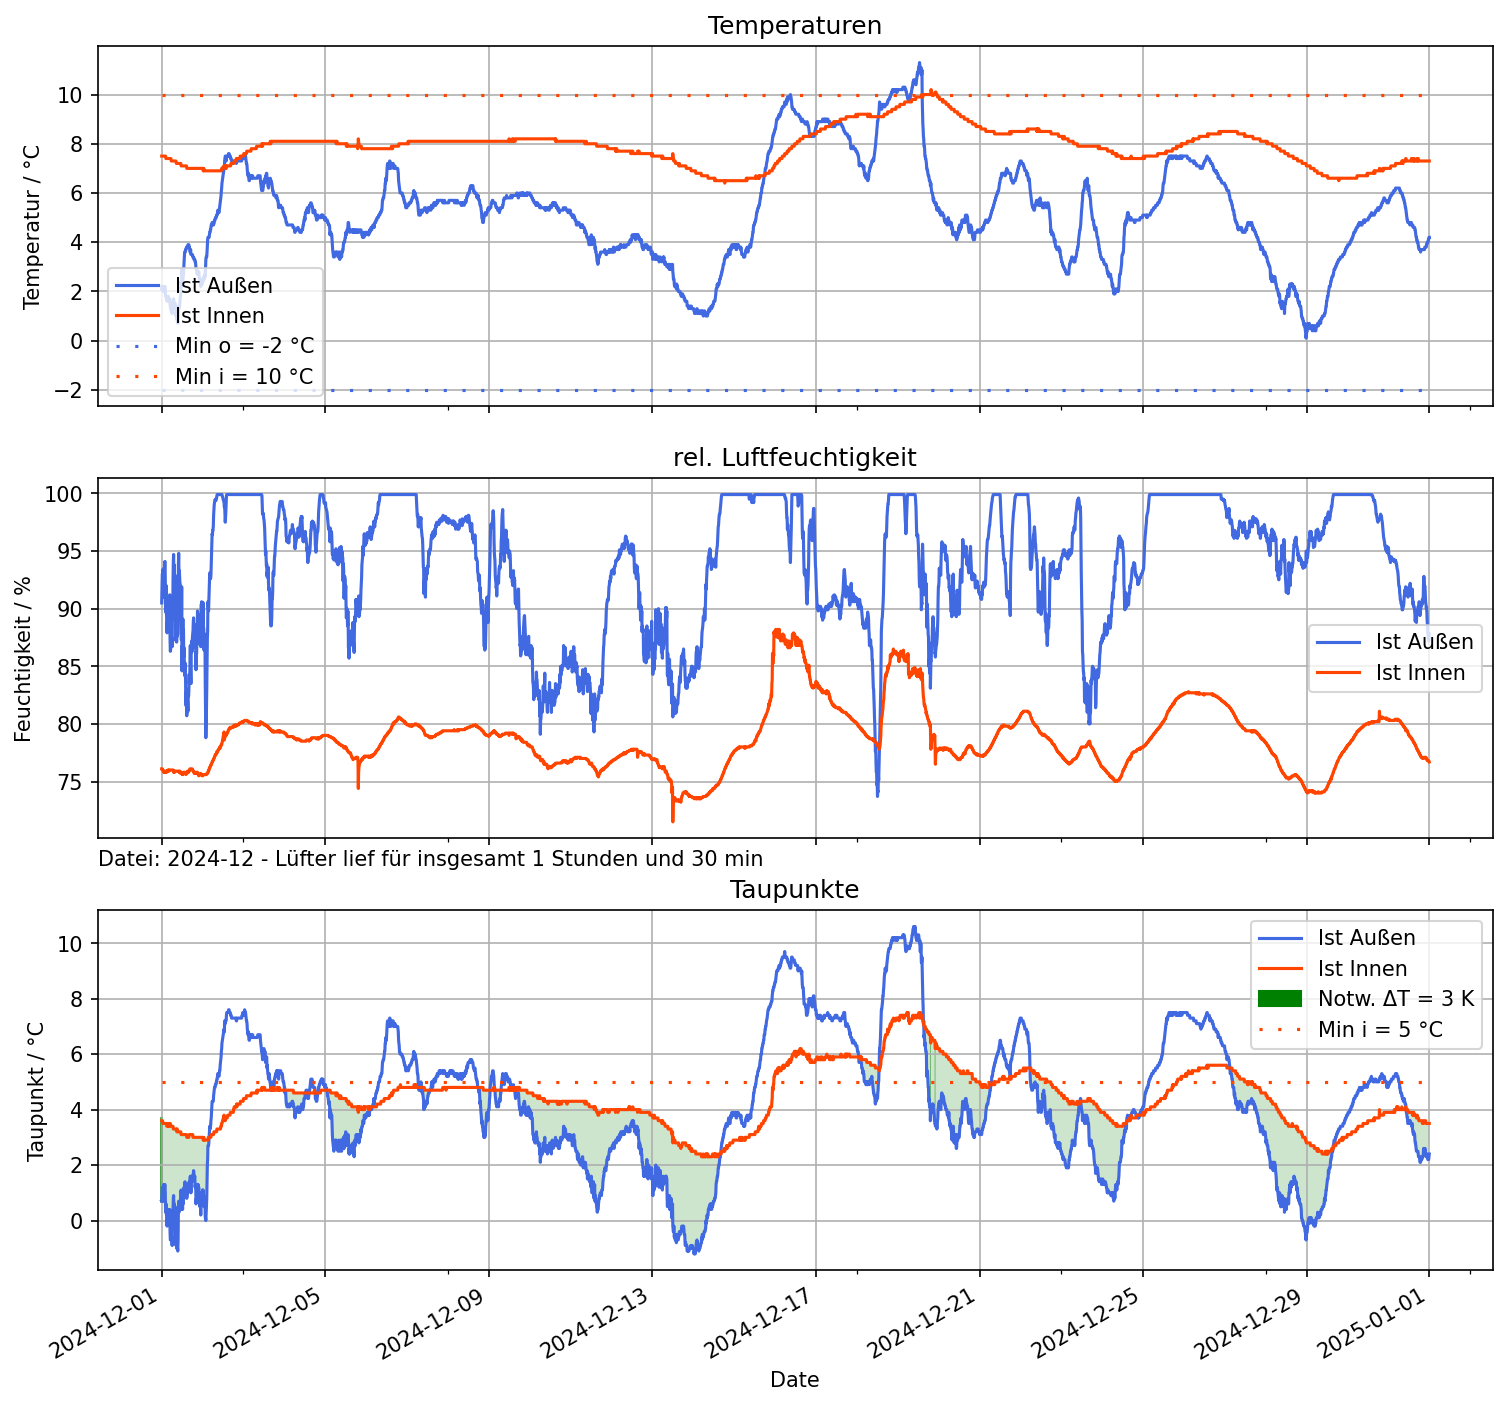

In [41]:
# create plots with german language labels
axisCount = 0;
plt.close('all')
fig, axes = plt.subplots(figsize=[12,12],dpi=150, nrows=3,ncols=1, sharex="all", clear=True);
axes[axisCount].set_title("Temperaturen");
axes[axisCount].set_ylabel("Temperatur / °C");
data[validO]["Temperature T_o"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Außen", color=colorO);
data[validI]["Temperature T_i"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Innen", color=colorI);
fig.axes[axisCount].plot(timeHelpVector,[minTemp_o, minTemp_o],linestyle=linestyleHelper, label= "Min o = "+str(minTemp_o)+" °C", color=colorO);
fig.axes[axisCount].plot(timeHelpVector,[minTemp_i, minTemp_i],linestyle=linestyleHelper, label= 'Min i = '+str(minTemp_i)+" °C", color=colorI);
fig.axes[axisCount].legend();
fig.axes[axisCount].grid(True);

axisCount = 1;
axes[axisCount].set_title("rel. Luftfeuchtigkeit");
axes[axisCount].set_ylabel("Feuchtigkeit / %")
data[validO]["Humidity H_o"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Außen", color=colorO)
data[validI]["Humidity H_i"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Innen", color=colorI);
fig.axes[axisCount].legend();
fig.axes[axisCount].grid(True);

axisCount = 2;
axes[axisCount].set_title("Taupunkte");
axes[axisCount].set_ylabel("Taupunkt / °C")
data[validO]["Dew point DP_o"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Außen", color=colorO)
data[validO]["Dew point DP_i"].plot.line(ax = axes[axisCount], marker='none', linestyle='-', label="Ist Innen", color=colorI);
d = data[validO].index.values

# fill in light green, when outside is drier than inside
axes[axisCount].fill_between(d, data[validO]["Dew point DP_o"], data[validO]["Dew point DP_i"],
                where=data[validO]["Dew point DP_o"] < data[validO]["Dew point DP_i"],
               facecolor='green', alpha=0.2, interpolate=True)

# fill in dark green, when ventilation is on
axes[axisCount].fill_between(d, data[validO]["Dew point DP_o"], data[validO]["Dew point DP_i"],
                where=data[validO]["Fan"]==1,
               facecolor='green', alpha=1, interpolate=True)
fig.axes[axisCount].arrow(timeHelpVector[0], data[validI]["Dew point DP_o"][0]+neccesDeltaP, 0, -neccesDeltaP, width=.01, label=u'Notw. ΔT = ' +str(neccesDeltaP)+" K", color='green');
fig.axes[axisCount].plot(timeHelpVector,[minDewPoint_i, minDewPoint_i],linestyle=linestyleHelper, label="Min i = "+str(minDewPoint_i)+" °C", color=colorI);
fig.axes[axisCount].legend();
fig.axes[axisCount].grid(True);

if (totalOnTime_s > 120):
    fig.text(0.125, 0.425, "Datei: "+fileNameOnly + " - Lüfter lief für insgesamt " + 
             str(totalOnTime_h) + " Stunden und " + 
             str(totalOnTime_Hmin) +" min");
else:
    fig.text(0.125, 0.425, "Datei: "+fileNameOnly + " - Lüfter lief für insgesamt " + str(totalOnTime_s/60) + " min");



In [42]:
# save figure with original filename, but as an png
fullPictureFileNamePath = path + os.path.sep + fileNameOnly + ".png";
fig.savefig(fname = fullPictureFileNamePath, bbox_inches ='tight', dpi = 150, pad_inches=.1)

# remove temporary file
try: os.remove(newFilename)
except FileNotFoundError: print("temporary file not deleted")